# Imports

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pandas as pd
from datetime import datetime 
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import pickle
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from arch import arch_model

In [20]:
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
ticker = yf.Ticker('aapl')
df = ticker.history(interval='1d', start='2010-01-01', end='2023-01-01')

# Creating dummy date index to prevent frequency warnings/errors (missing value imputation not necessary because there should
# be no data on days the market is not open)
dummy_dates = pd.date_range(end=datetime.today(), periods=len(df))
df['Dummy Date'] = dummy_dates.date
df.index = df.index.tz_convert(None)
df = df.reset_index()
df = df.set_index('Dummy Date')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Dummy Date,,,,,,,,
2014-05-06,2010-01-04 05:00:00,6.487649,6.520174,6.455732,6.505280,493729600,0.0,0.0
2014-05-07,2010-01-05 05:00:00,6.523216,6.553309,6.482179,6.516528,601904800,0.0,0.0
2014-05-08,2010-01-06 05:00:00,6.516527,6.542364,6.406185,6.412873,552160000,0.0,0.0
2014-05-09,2010-01-07 05:00:00,6.436582,6.444182,6.354510,6.401017,477131200,0.0,0.0
2014-05-10,2010-01-08 05:00:00,6.392506,6.444181,6.354814,6.443573,447610800,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3272 entries, 2014-05-06 to 2023-04-20
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3272 non-null   datetime64[ns]
 1   Open          3272 non-null   float64       
 2   High          3272 non-null   float64       
 3   Low           3272 non-null   float64       
 4   Close         3272 non-null   float64       
 5   Volume        3272 non-null   int64         
 6   Dividends     3272 non-null   float64       
 7   Stock Splits  3272 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 230.1+ KB


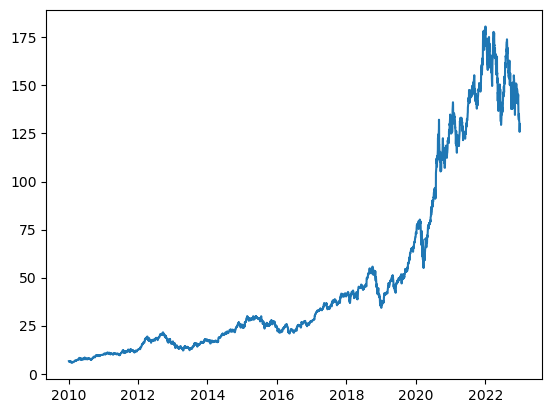

In [4]:
plt.plot(df['Date'], df['Close'])
plt.show()

# Stationarity

In [5]:
result = adfuller(df['Close'])
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -0.21779658211720473
ADF P-value: 0.9363667980985891


Based on the p-value of the ADF test, we fail to reject the null hypothesis and therefore, the data is not stationary.

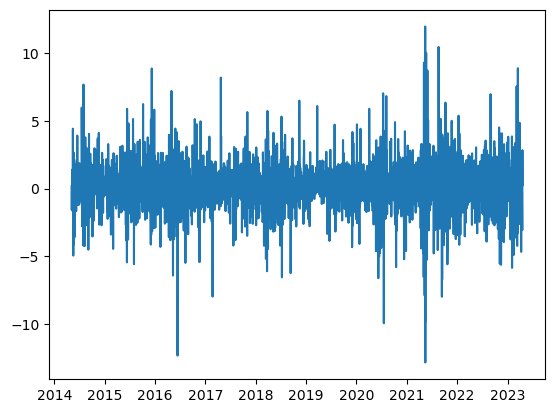

In [8]:
returns = 100 * df['Close'].pct_change().dropna()
plt.plot(returns)
plt.show()

In [9]:
result = adfuller(returns)
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -11.70007555447562
ADF P-value: 1.5763971855661435e-21


By taking the first difference of the closing price, we see that the resulting p-value of the ADF test is now less than 0.05, so we can reject the null hypothesis and conclude that the returns are stationary. We also can conlude that the parameter, d, corresponding to the integrated component of our SARIMA model should be set to 1.

# Train/Test Split

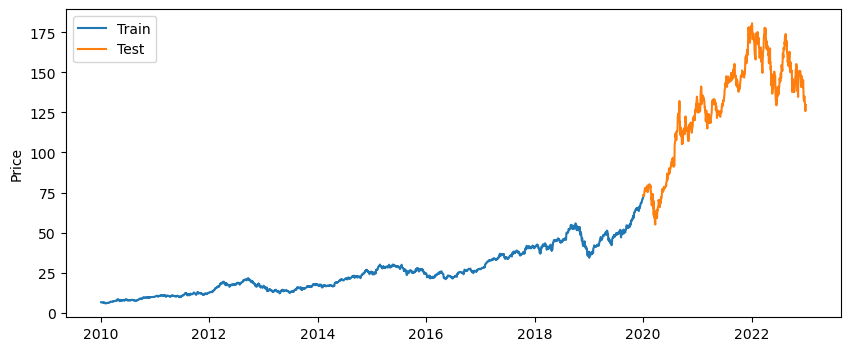

In [11]:
max_date = df.loc[df['Date'] < datetime(2020, 1, 1)].index.max()
max_train_idx = df.index.get_loc(max_date)

plt.figure(figsize=(10,4))
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='Train')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='Test')
plt.ylabel('Price')
plt.legend()
plt.show()

# PACF and ACF Plots

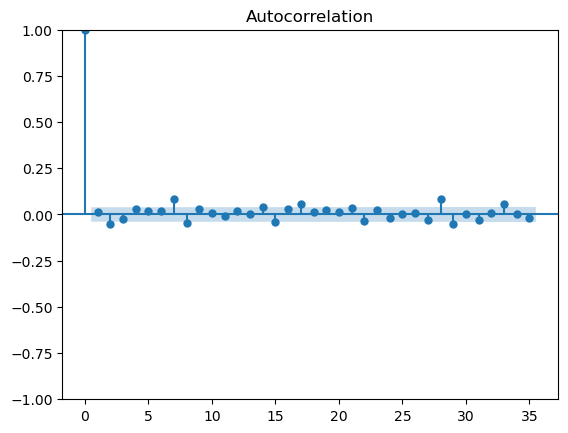

In [14]:
plot_acf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna())
plt.show()

Based on the ACF plot, possible values of the moving average (MA) component of the model could be {2, 7, 8}

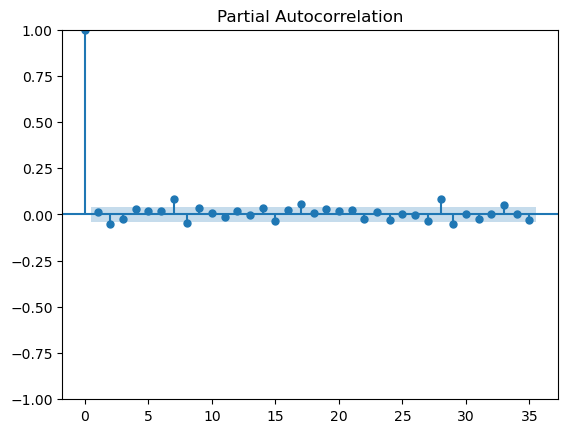

In [16]:
plot_pacf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna(), method='ywm')
plt.show()

Based on the PACF plot, possible values of the autoregressive (AR) component of the model could be {2, 7, 8}

# ARIMA Parameter Tuning

In [25]:
# ARIMA (8, 1, 8)
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(8, 1, 8), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(8, 1, 8)   Log Likelihood               -1546.531
Date:                Thu, 20 Apr 2023   AIC                           3127.061
Time:                        18:23:51   BIC                           3226.172
Sample:                    05-06-2014   HQIC                          3163.032
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1445     14.447     -0.010      0.992     -28.461      28.172
ar.L2          0.1938      7.765      0.025      0.980     -15.025      15.413
ar.L3          0.2410      0.313      0.770      0.441      -0.372       0.854
ar.L4          0.0354      3.322      0.011      0.991      -6.476       6.547
ar.L5          0.2138      1.814      0.118      0.906      -3.341       3.769
ar.L6          0.0544      3.888      0.014      0.989      -7.565       7.674
ar.L7          0.4215      2.388      0.177      0.860      -4.258       5.101
ar.L8         -0.1858      7.000     -0.027      0.979     -13.906      13.535
ma.L1          0.1649     14.448      0.011      0.991     -28.153      28.483
ma.L2         -0.2422      8.058     -0.030      0.976     -16.035      15.551
ma.L3         -0.2765      0.325     -0.850      0.395      -0.914       0.361
ma.L4          0.0053      4.067      0.001      0.999      -7.966       7.976
ma.L5         -0.1748      1.523     -0.115      0.909      -3.160       2.810
ma.L6         -0.0316      3.216     -0.010      0.992      -6.335       6.272
ma.L7         -0.3380      1.797     -0.188      0.851      -3.861       3.185
ma.L8          0.1454      5.555      0.026      0.979     -10.742      11.033
sigma2         0.2004      0.003     73.491      0.000       0.195       0.206
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7124.20
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               7.38   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see that none of the AR and MA coefficients of the model are significant, so this is a bad choice.

In [26]:
# ARIMA (2, 1, 8)
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(2, 1, 8), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(2, 1, 8)   Log Likelihood               -1555.552
Date:                Thu, 20 Apr 2023   AIC                           3133.104
Time:                        18:25:32   BIC                           3197.234
Sample:                    05-06-2014   HQIC                          3156.379
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6517      0.049    -33.477      0.000      -1.748      -1.555
ar.L2         -0.8150      0.046    -17.688      0.000      -0.905      -0.725
ma.L1          1.6726      0.050     33.147      0.000       1.574       1.771
ma.L2          0.8005      0.053     14.988      0.000       0.696       0.905
ma.L3         -0.0870      0.026     -3.297      0.001      -0.139      -0.035
ma.L4         -0.0385      0.027     -1.450      0.147      -0.091       0.014
ma.L5          0.0736      0.028      2.592      0.010       0.018       0.129
ma.L6          0.1006      0.028      3.636      0.000       0.046       0.155
ma.L7          0.1212      0.024      5.017      0.000       0.074       0.169
ma.L8          0.0758      0.014      5.473      0.000       0.049       0.103
sigma2         0.2015      0.003     74.797      0.000       0.196       0.207
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              7608.73
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               7.39   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# ARIMA (2, 1, 7)
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(2, 1, 7), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(2, 1, 7)   Log Likelihood               -1559.059
Date:                Thu, 20 Apr 2023   AIC                           3138.118
Time:                        18:29:30   BIC                           3196.418
Sample:                    05-06-2014   HQIC                          3159.277
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6766      0.142     -4.772      0.000      -0.954      -0.399
ar.L2         -0.2090      0.129     -1.616      0.106      -0.463       0.044
ma.L1          0.6933      0.141      4.904      0.000       0.416       0.970
ma.L2          0.1717      0.130      1.325      0.185      -0.082       0.426
ma.L3         -0.0547      0.017     -3.314      0.001      -0.087      -0.022
ma.L4          0.0139      0.018      0.755      0.451      -0.022       0.050
ma.L5          0.0444      0.016      2.750      0.006       0.013       0.076
ma.L6          0.0483      0.016      3.089      0.002       0.018       0.079
ma.L7          0.0964      0.014      6.980      0.000       0.069       0.123
sigma2         0.2023      0.003     72.656      0.000       0.197       0.208
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7398.85
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               7.41   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# ARIMA (2, 1, 2)
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(2, 1, 2), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1568.731
Date:                Thu, 20 Apr 2023   AIC                           3147.462
Time:                        18:29:50   BIC                           3176.612
Sample:                    05-06-2014   HQIC                          3158.042
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2305      0.002    535.842      0.000       1.226       1.235
ar.L2         -0.9969      0.002   -472.167      0.000      -1.001      -0.993
ma.L1         -1.2377      0.003   -458.519      0.000      -1.243      -1.232
ma.L2          0.9966      0.003    385.191      0.000       0.992       1.002
sigma2         0.2037      0.003     76.192      0.000       0.198       0.209
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):              7851.56
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               7.52   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comparing the ARIMA(2, 1, 8), ARIMA(2, 1, 7), and ARIMA(2, 1, 2), we see that the majority of every model's coefficients are statistically significant. Therefore, we will choose a model based on AIC. The ARIMA(2, 1, 8) model has the lowest AIC, so we will choose to optimize that model by removing any insignificant lags.

# ARIMA (2, 1, 8) Model

In [32]:
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(2, 1, (1, 1, 1, 0, 1, 1, 1, 1)), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Close   No. Observations:                 2516
Model:             ARIMA(2, 1, [1, 2, 3, 5, 6, 7, 8])   Log Likelihood               -1557.062
Date:                                Thu, 20 Apr 2023   AIC                           3134.125
Time:                                        18:33:33   BIC                           3192.425
Sample:                                    05-06-2014   HQIC                          3155.284
                                         - 03-25-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4766      0.091    -16.222      0.000      -1.655      -1.298
ar.L2         -0.6657      0.069     -9.717      0.000      -0.800      -0.531
ma.L1          1.4913      0.092     16.273      0.000       1.312       1.671
ma.L2          0.6477      0.074      8.696      0.000       0.502       0.794
ma.L3         -0.0593      0.019     -3.184      0.001      -0.096      -0.023
ma.L5          0.0764      0.019      4.061      0.000       0.040       0.113
ma.L6          0.0835      0.024      3.469      0.001       0.036       0.131
ma.L7          0.1241      0.023      5.403      0.000       0.079       0.169
ma.L8          0.0765      0.018      4.344      0.000       0.042       0.111
sigma2         0.2020      0.003     73.502      0.000       0.197       0.207
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7510.41
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               7.38   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now all the coefficients are significant, so we can visualize the results of our model.

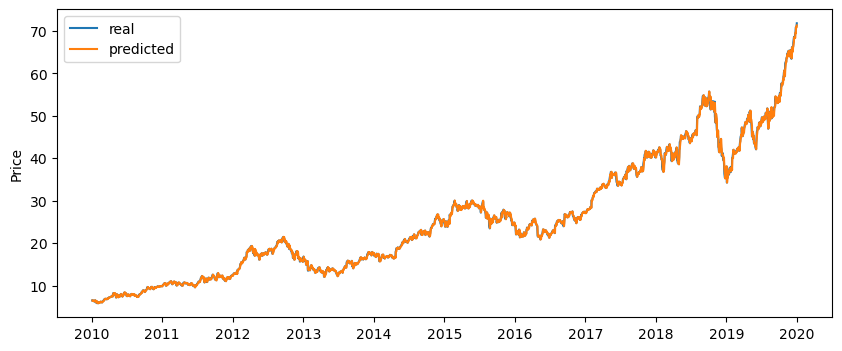

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='real')
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], results.fittedvalues[1:], label='predicted')
plt.legend()
plt.ylabel('Price')
plt.show()

In [35]:
# Train Results
mse = mean_squared_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mae = mean_absolute_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mape = mean_absolute_percentage_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 0.201957692570617
RMSE: 0.4493970322227518
MAE: 0.28674744211998815
MAPE: 0.011640369162104742


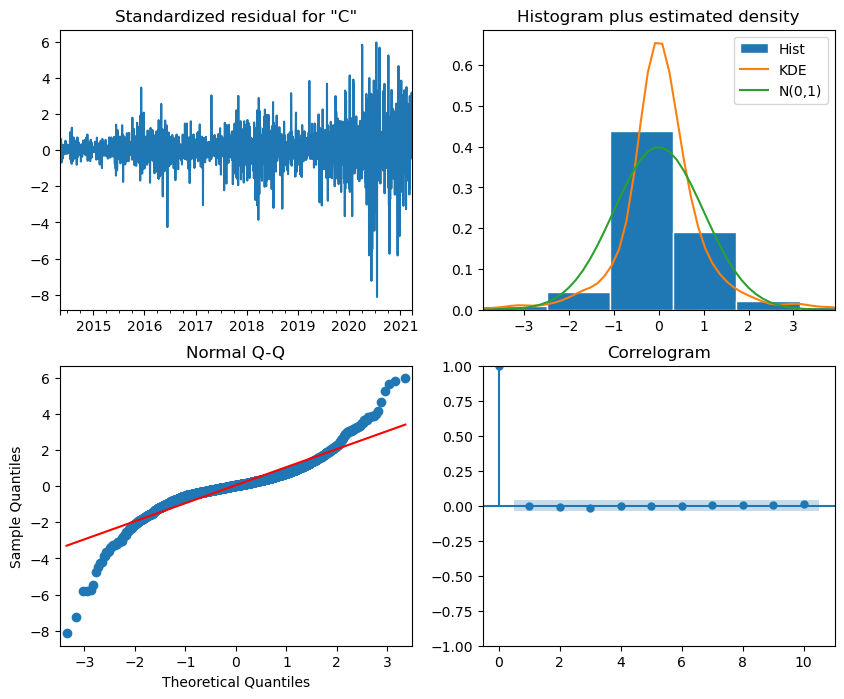

In [36]:
fig = plt.figure(figsize=(10, 8))
results.plot_diagnostics(fig=fig)
plt.show()

Based on the diagnostic plots, the residuals do appear to be normally distributed with mean 0 and do not appear to be correlated. However, it is clear that there is a change in volatility over time -> heteroskedasticity. To confirm these conclusions, we run an Ljung-Box test to check for autocorrelation and a Breusch Pagan test to check for heteroskedasticity. 

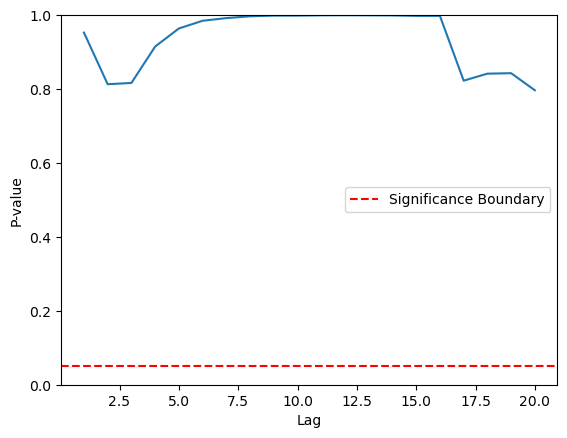

In [38]:
# Use Ljung-Box to statistically test for autocorrelation of residuals in the first 20 lags
resid_test = acorr_ljungbox(results.resid, lags=20, return_df=True)
plt.plot(resid_test['lb_pvalue'])
plt.axhline(0.05, linestyle='--', color='red', label='Significance Boundary')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('P-value')
plt.xlabel('Lag')
plt.show()

The null hypothesis of the Ljung-Box test is that the residuals are independently distributed. Based on the figure above, we fail to reject the null hypothesis for the first 20 lags and conclude that the residuals are independently distributed (i.e. they do not exhibit serial correlation).

In [39]:
# Breusch-Pagan test for heteroskedasticity
n = len(df.iloc[1:max_train_idx + 1]) 
exog = np.zeros((n, 2))
exog[:, 0], exog[:, 1] = df.iloc[1:max_train_idx + 1]['Date'], df.iloc[1:max_train_idx + 1]['Close']

bp_test = het_breuschpagan(results.resid[1:], exog)
print('BP Test Statistic: {}'.format(bp_test[0]))
print('BP P-value: {}'.format(bp_test[1]))

BP Test Statistic: 26.98043780323378
BP P-value: 2.055250060287756e-07


Based on the results of the Breusch Pagan test, we reject the null hypothesis that the residuals are homoskedastic and conclude that there is a change in variance/volatility over time. To model this volatility we will use a GARCH model.

# Rolling Forecast Origin

In [40]:
predictions = results.fittedvalues.to_list()

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    model = SARIMAX(df.iloc[i:max_train_idx + 1 + i]['Close'], order=(2, 1, (1, 1, 1, 0, 1, 1, 1, 1)), 
                    initialization='approximate_diffuse').fit(maxiter=200)
    
    # Forecast
    forecast = model.forecast()[0]
    predictions.append(forecast)

df['Close Predictions'] = predictions

100%|████████████████████████████████████████████████████████████████████████████████| 756/756 [50:32<00:00,  4.01s/it]


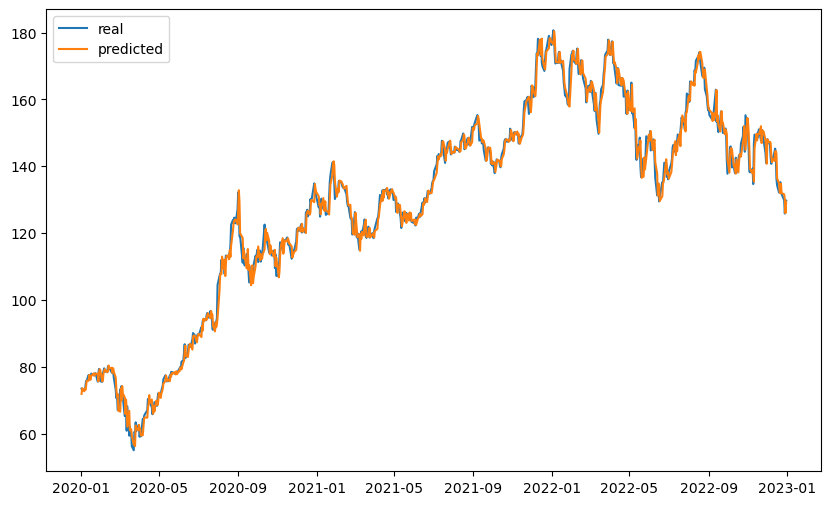

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='real')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close Predictions'], label='predicted')
plt.legend()
plt.show()

In [42]:
# Test Results
mse = mean_squared_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mae = mean_absolute_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mape = mean_absolute_percentage_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 7.894131783493181
RMSE: 2.809649761712869
MAE: 2.117747452108883
MAPE: 0.017121840922457797


# Modeling Volatility

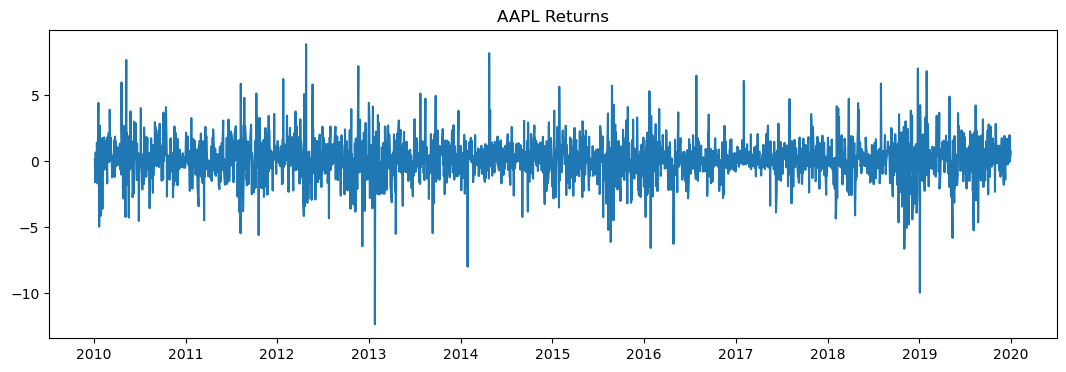

In [43]:
returns = 100 * df.iloc[:max_train_idx + 1]['Close'].pct_change().dropna()

plt.figure(figsize=(13, 4))
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], returns)
plt.title('AAPL Returns')
plt.show()

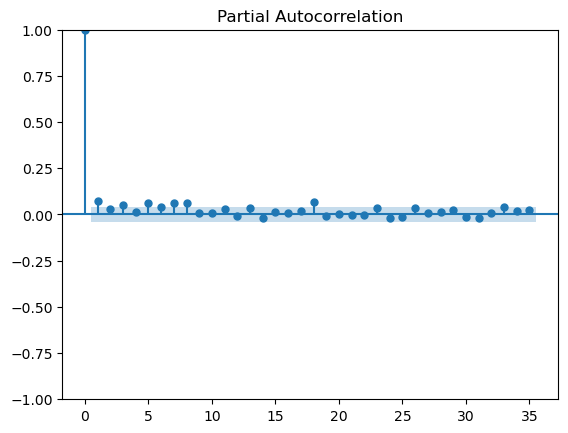

In [44]:
# PACF to determine order of AR component
plot_pacf(returns ** 2)
plt.show()

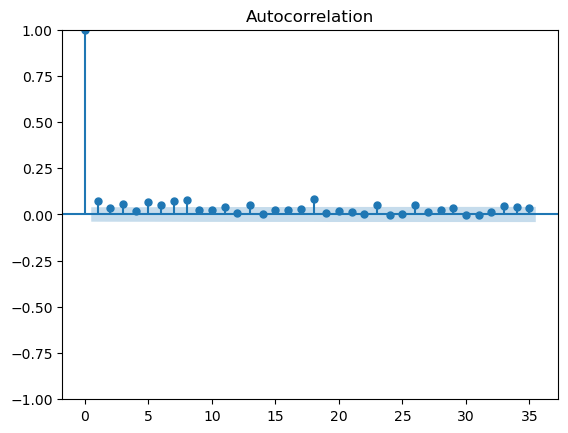

In [45]:
# ACF to determine order of MA component
plot_acf(returns ** 2)
plt.show()

Based on the acf/pacf plots, possible orders of the MA component include {1, 3, 5, 6, 7, 8} and possible orders of the AR component include {1, 3, 5, 7, 8}.

In [52]:
# GARCH(1, 1)
model_fit = arch_model(returns, p=1, q=1, vol='Garch').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15081.43296184334
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2057039.449465031
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4860.394721081395
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4728.795747504722
Iteration:      5,   Func. Count:     36,   Neg. LLF: 4709.5399584937695
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4695.171991538949
Iteration:      7,   Func. Count:     48,   Neg. LLF: 4687.921010888676
Iteration:      8,   Func. Count:     53,   Neg. LLF: 4687.91591964396
Iteration:      9,   Func. Count:     58,   Neg. LLF: 4687.915851212417
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4687.915848209697
Iteration:     11,   Func. Count:     67,   Neg. LLF: 4687.915848211087
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4687.915848209697
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11

In [53]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4687.92
Distribution:                  Normal   AIC:                           9383.83
Method:            Maximum Likelihood   BIC:                           9407.15
                                        No. Observations:                 2515
Date:                Thu, Apr 20 2023   Df Residuals:                     2514
Time:                        21:02:11   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1792  3.248e-02      5.517  3.442e-08 [  0.116,  0.243]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2003  6.636e-02      3.018  2.545e-03 [7.021e-02,  0.330]
alpha[1]       0.1084  2.826e-02      3.837  1.248e-04 [5.303e-02,  0.164]
beta[1]        0.8203  4.179e-02     19.629  8.700e-86   [  0.738,  0.902]
==========================================================================

Covariance estimator: robust
"""

From the model summary, we can see that all the coefficients are statistically significant. We can try a GARCH(3, 3) to see if any later lags are also signficant.

In [58]:
# GARCH(3, 3)
model_fit = arch_model(returns, p=3, q=3, vol='Garch').fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 16562.550540852542
Iteration:      2,   Func. Count:     23,   Neg. LLF: 11985.289423658127
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5505.175383782895
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4809.838487298308
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4900.533930025984
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4693.932594642066
Iteration:      7,   Func. Count:     76,   Neg. LLF: 4717.792286355429
Iteration:      8,   Func. Count:     86,   Neg. LLF: 4692.921725711893
Iteration:      9,   Func. Count:     96,   Neg. LLF: 4684.6471333039135
Iteration:     10,   Func. Count:    106,   Neg. LLF: 4687.656111969303
Iteration:     11,   Func. Count:    116,   Neg. LLF: 4683.634617697596
Iteration:     12,   Func. Count:    126,   Neg. LLF: 4683.669623484893
Iteration:     13,   Func. Count:    136,   Neg. LLF: 4683.576455509644
Iteration:     14,   Func. Count:    146,   Neg. LLF: 4683.49

In [59]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4683.49
Distribution:                  Normal   AIC:                           9382.98
Method:            Maximum Likelihood   BIC:                           9429.62
                                        No. Observations:                 2515
Date:                Thu, Apr 20 2023   Df Residuals:                     2514
Time:                        21:06:05   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1745  3.309e-02      5.274  1.334e-07 [  0.110,  0.239]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3535      0.453      0.780      0.435      [ -0.534,  1.241]
alpha[1]       0.1621  4.454e-02      3.640  2.729e-04    [7.482e-02,  0.249]
alpha[2]       0.0299      0.220      0.136      0.892      [ -0.401,  0.461]
alpha[3]       0.0000  2.377e-02      0.000      1.000 [-4.659e-02,4.659e-02]
beta[1]        0.0459      1.347  3.403e-02      0.973      [ -2.595,  2.686]
beta[2]        0.5839      0.224      2.610  9.066e-03      [  0.145,  1.022]
beta[3]        0.0534      0.781  6.847e-02      0.945      [ -1.477,  1.584]
=============================================================================

Covariance estimator: robust
"""

We can see that the majority of coefficients are insignificant, so we'll stick with the GARCH(1, 1) model.

In [60]:
# Rolling Forecast Origin
vol_preds = [np.nan for _ in range(max_train_idx + 1)] # pad training data with nan values because we only predict on test set

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    returns = 100 * df.iloc[i:i + max_train_idx + 1]['Close'].pct_change().dropna()
    model_fit = arch_model(returns, p=1, q=1, vol='Garch').fit(disp='off')
    
    # Forecast
    forecast = model_fit.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1][0])
    vol_preds.append(vol)

df['Volatility Predictions'] = vol_preds

100%|████████████████████████████████████████████████████████████████████████████████| 756/756 [00:21<00:00, 34.85it/s]


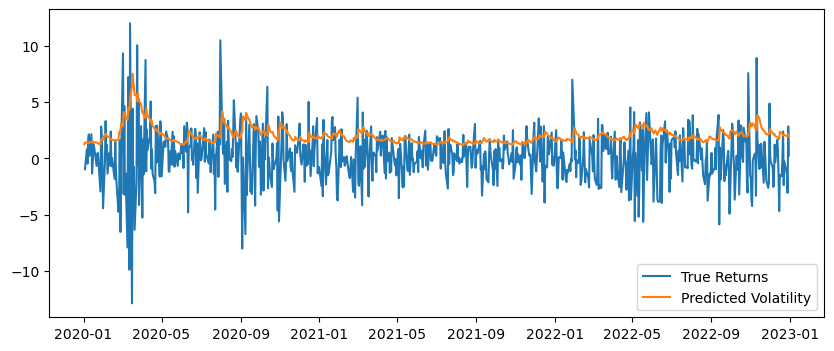

In [61]:
plt.figure(figsize=(10, 4))
true_returns = 100 * df.iloc[max_train_idx + 1:]['Close'].pct_change().dropna()
plt.plot(df.iloc[max_train_idx + 2:]['Date'], true_returns, label='True Returns')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Volatility Predictions'], 
         label='Predicted Volatility')
plt.legend()
plt.show()

We see that the model does a great job of modeling the volatility of the stock's returns.

In [62]:
# Saving Data
df = df.set_index('Date')
df['Returns'] = 100 * df['Close'].pct_change()
df['Test Marker'] = [np.nan if x != max_train_idx + 1 else 'Start of Test Data' for x in range(len(df))]
df.to_csv('Processed Apple Data.csv')